## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


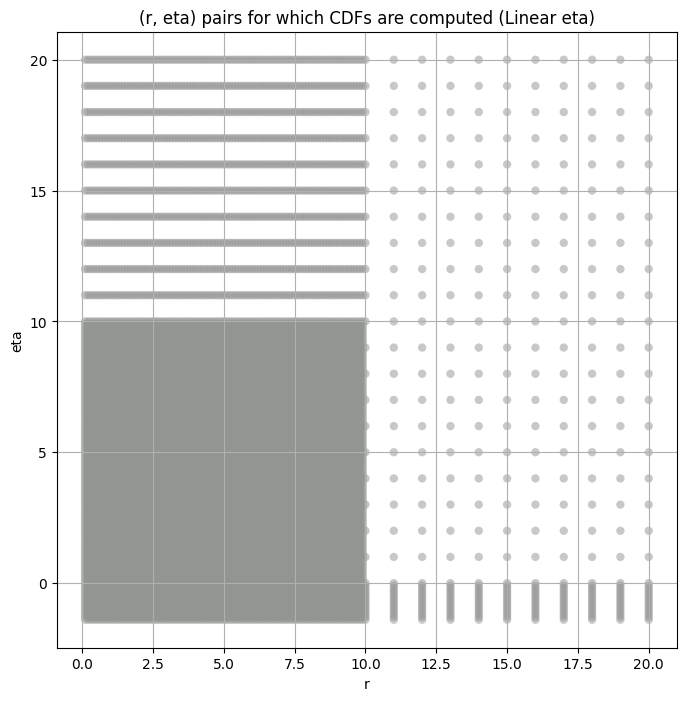

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [02:12<00:00, 755.92it/s]


Layer 3


100%|██████████| 100000/100000 [01:02<00:00, 1594.82it/s]


Layer 4


100%|██████████| 100000/100000 [01:01<00:00, 1623.15it/s]


Layer 5


100%|██████████| 100000/100000 [01:00<00:00, 1647.94it/s]


Layer 6


100%|██████████| 100000/100000 [00:53<00:00, 1870.73it/s]


Layer 7


100%|██████████| 100000/100000 [00:43<00:00, 2318.49it/s]


Layer 8


100%|██████████| 100000/100000 [00:43<00:00, 2297.12it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2115.980000  1901.711800  2349.228000   3.403383    1.992058   
3       673.217470   635.692300   712.868700   3.037643    2.285118   
4       188.343120   177.020320   200.117230   3.632319    2.853501   
5        43.649445    40.704983    46.747660   5.291733    4.145431   
6         8.706341     8.027619     9.425082   7.502429    5.632719   
7         1.620481     1.481642     1.770143  10.018490    7.480563   
8         0.253562     0.229370     0.281929  13.938591    9.163198   

       kurt_upper  total_samples  
layer                             
2        4.968096         3180.0  
3        3.923036        12720.0  
4        4.629042        50880.0  
5        6.736124       203520.0  
6       10.357133       814080.0  
7       14.607306      3256320.0  
8       30.660614     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      2115.980000    2115.979980     1662.387817     1456.055176   
3       673.217470     673.217468      616.784668      584.915222   
4       188.343120     188.343124      182.216568      178.198563   
5        43.649445      43.649445       42.604782       41.868298   
6         8.706341       8.706341        8.438324        8.264395   
7         1.620481       1.620481        1.562010        1.524389   
8         0.253562       0.253562        0.242039        0.235297   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1302.058105      1179.015991       990.648682       844.277161   
3          558.536499       535.810303       497.228577       466.126312   
4          174.778824       171.736984       166.379364       161.691742   
5           41.239948        40.679733        39.709511        38.861660   
6            8.118723         7.989503         7.764991         7.571101   
7            1.493075         1.465603         1.417892         1.376760   
8            0.229783         0.224983         0.216737         0.209690   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           727.871643       631.755310       548.590027       368.138763  
3           439.584198       416.351318       395.544250       343.466766  
4           157.453217       153.557007       149.972214       140.672104  
5            38.098026        37.399357        36.749996        35.023266  
6             7.397577         7.239896         7.094322         6.712564  
7             1.340144         1.306986         1.276542         1.197271  
8             0.203468         0.197862         0.192748         0.179560

####
Layer  2


100%|██████████| 12760/12760 [00:02<00:00, 4627.55it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.018264043866442425 2115.98


100%|██████████| 12760/12760 [00:01<00:00, 7782.47it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.018609557773644148 1662.3878


100%|██████████| 12760/12760 [00:01<00:00, 7179.22it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.0274402315015726 1456.0552


100%|██████████| 12760/12760 [00:01<00:00, 7085.02it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.036581156556510175 1302.0581


100%|██████████| 12760/12760 [00:01<00:00, 7406.04it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.04622330705965205 1179.016


100%|██████████| 12760/12760 [00:01<00:00, 8464.95it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.060542350949788326 990.6487


100%|██████████| 12760/12760 [00:01<00:00, 6570.09it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07375154101468995 844.27716


100%|██████████| 12760/12760 [00:01<00:00, 7712.36it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.08779436735584722 727.87164


100%|██████████| 12760/12760 [00:01<00:00, 8626.55it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.10166154393475357 631.7553


100%|██████████| 12760/12760 [00:01<00:00, 7825.16it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11566619658470989 548.59


100%|██████████| 12760/12760 [00:01<00:00, 8568.61it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.1569174754686936 368.13876
Number of samples: 3180, Without approximation : 3180.0


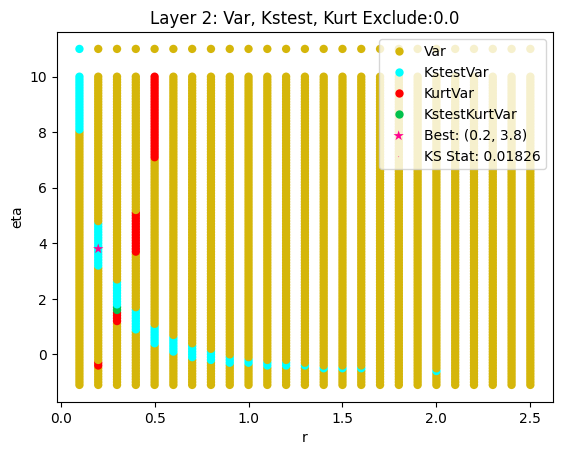

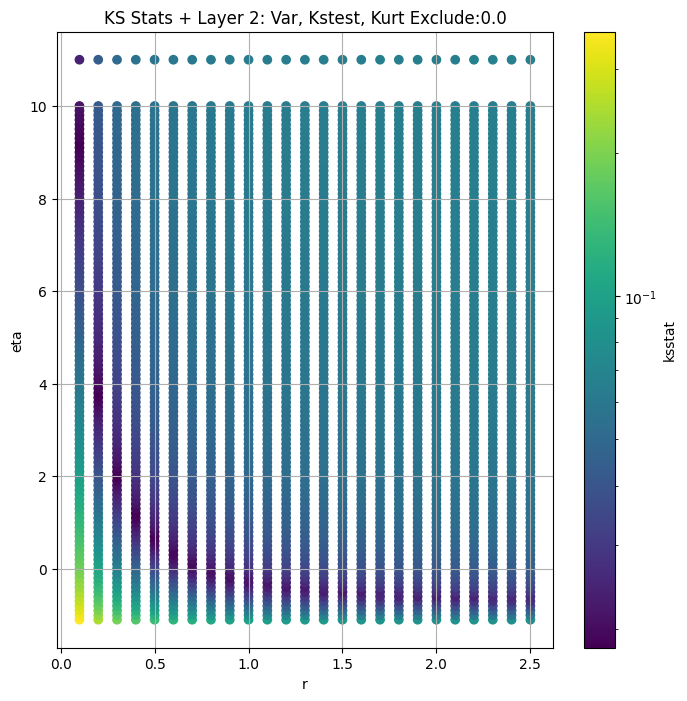

####
Layer  3


100%|██████████| 12760/12760 [00:06<00:00, 1823.17it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.004540300105681738 673.21747


100%|██████████| 12760/12760 [00:05<00:00, 2316.06it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.005964328942526048 616.78467


100%|██████████| 12760/12760 [00:06<00:00, 1982.48it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.008147205427300519 584.9152


100%|██████████| 12760/12760 [00:06<00:00, 1929.17it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.0102215913484206 558.5365


100%|██████████| 12760/12760 [00:05<00:00, 2363.40it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.01265002226503853 535.8103


100%|██████████| 12760/12760 [00:05<00:00, 2438.94it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.017194742668505736 497.22858


100%|██████████| 12760/12760 [00:05<00:00, 2469.88it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.021209947099324333 466.1263


100%|██████████| 12760/12760 [00:05<00:00, 2416.43it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.025249944225942844 439.5842


100%|██████████| 12760/12760 [00:05<00:00, 2412.60it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.02945147303833351 416.35132


100%|██████████| 12760/12760 [00:05<00:00, 2525.55it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.033742656283414885 395.54425


100%|██████████| 12760/12760 [00:05<00:00, 2164.34it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.045770981431416446 343.46677
Number of samples: 12720, Without approximation : 12720.0


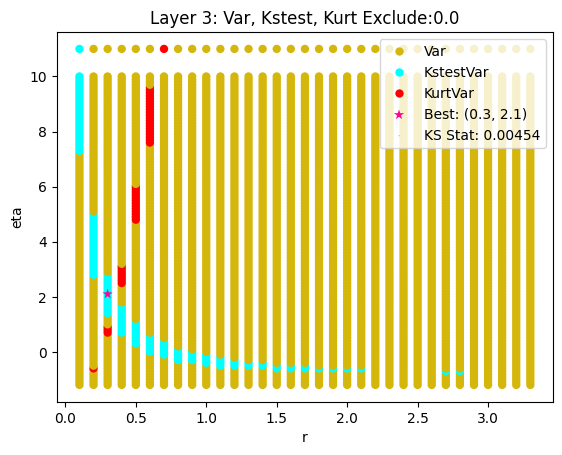

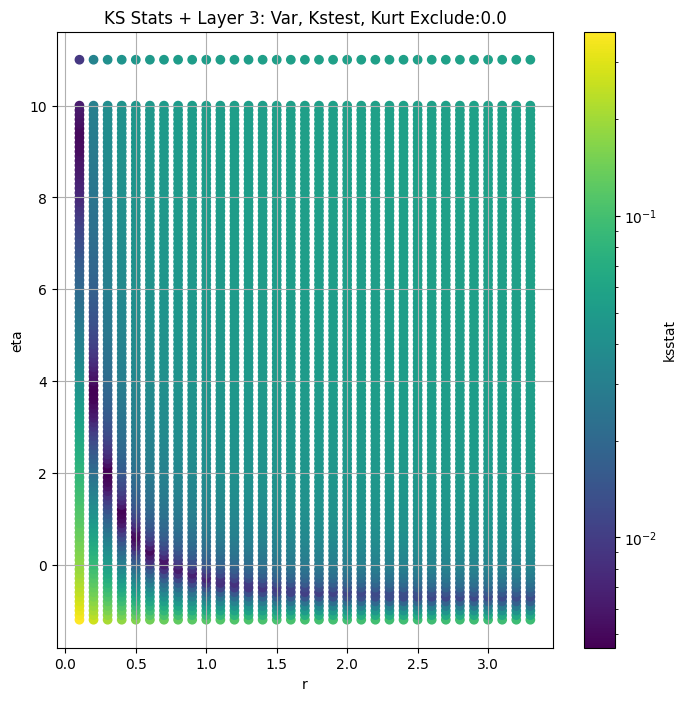

####
Layer  4


100%|██████████| 12760/12760 [00:19<00:00, 651.01it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005316443423275752 188.34312


100%|██████████| 12760/12760 [00:19<00:00, 670.13it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.005056159134915639 182.21657


100%|██████████| 12760/12760 [00:18<00:00, 687.40it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.005589277420450012 178.19856


100%|██████████| 12760/12760 [00:18<00:00, 682.18it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.005503031028389782 174.77882


100%|██████████| 12760/12760 [00:18<00:00, 693.73it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.006009545523800175 171.73698


100%|██████████| 12760/12760 [00:19<00:00, 642.09it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.0068873591483961105 166.37936


100%|██████████| 12760/12760 [00:19<00:00, 648.20it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.007915844496104385 161.69174


100%|██████████| 12760/12760 [00:18<00:00, 677.93it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.009162934798879863 157.45322


100%|██████████| 12760/12760 [00:18<00:00, 676.84it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010335612166218588 153.557


100%|██████████| 12760/12760 [00:19<00:00, 660.28it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011506048627394239 149.97221


100%|██████████| 12760/12760 [00:20<00:00, 637.94it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014732071864074658 140.6721
Number of samples: 50880, Without approximation : 50880.0


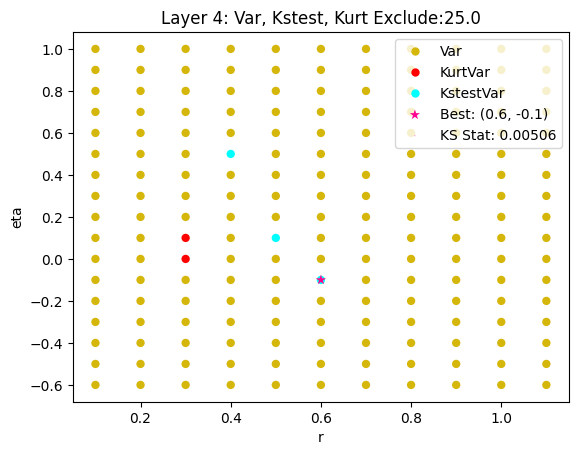

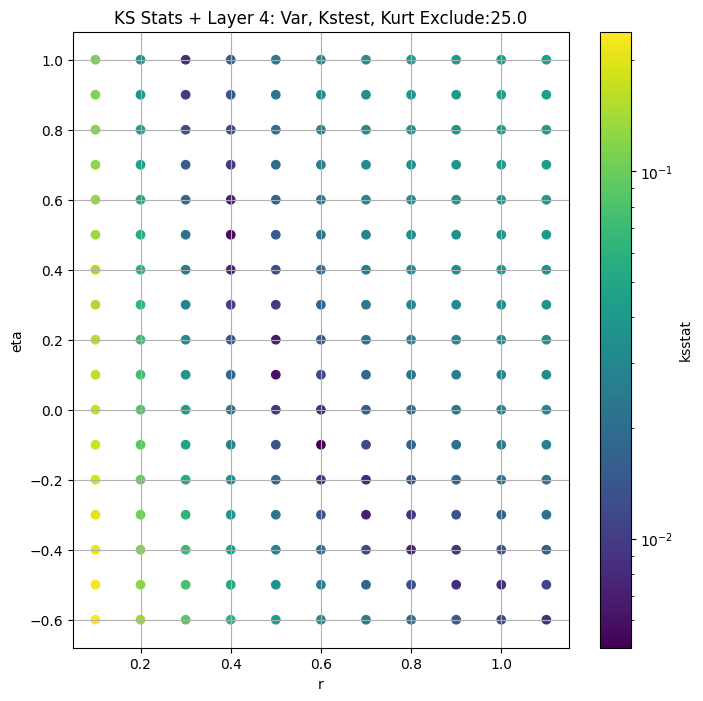

####
Layer  5


100%|██████████| 12760/12760 [00:36<00:00, 345.79it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.001980108018862836 43.649445


100%|██████████| 12760/12760 [00:38<00:00, 327.24it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.0025508433182166446 42.604782


100%|██████████| 12760/12760 [00:42<00:00, 302.59it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.002942132722705826 41.868298


100%|██████████| 12760/12760 [00:38<00:00, 329.09it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.003648248944973842 41.23995


100%|██████████| 12760/12760 [00:40<00:00, 315.67it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.0037062152554316885 40.679733


100%|██████████| 12760/12760 [00:39<00:00, 324.90it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.004149202152207487 39.70951


100%|██████████| 12760/12760 [00:39<00:00, 319.51it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.004737059659559728 38.86166


100%|██████████| 12760/12760 [00:39<00:00, 323.55it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.005445446791222164 38.098026


100%|██████████| 12760/12760 [00:41<00:00, 310.96it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006089868320038827 37.399357


100%|██████████| 12760/12760 [00:39<00:00, 321.04it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006624340375300575 36.749996


100%|██████████| 12760/12760 [00:42<00:00, 297.88it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008435889742333336 35.023266
Number of samples: 100000, Without approximation : 203520.0


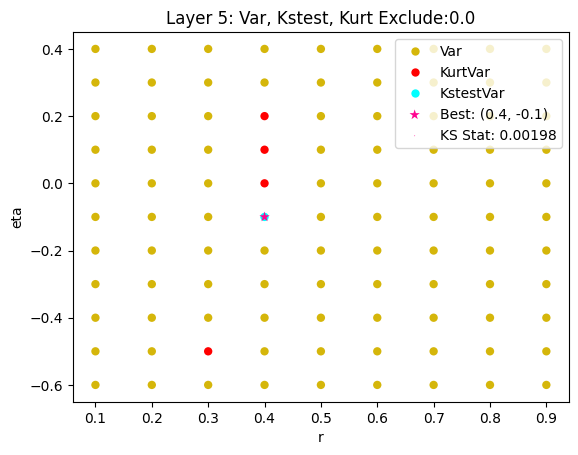

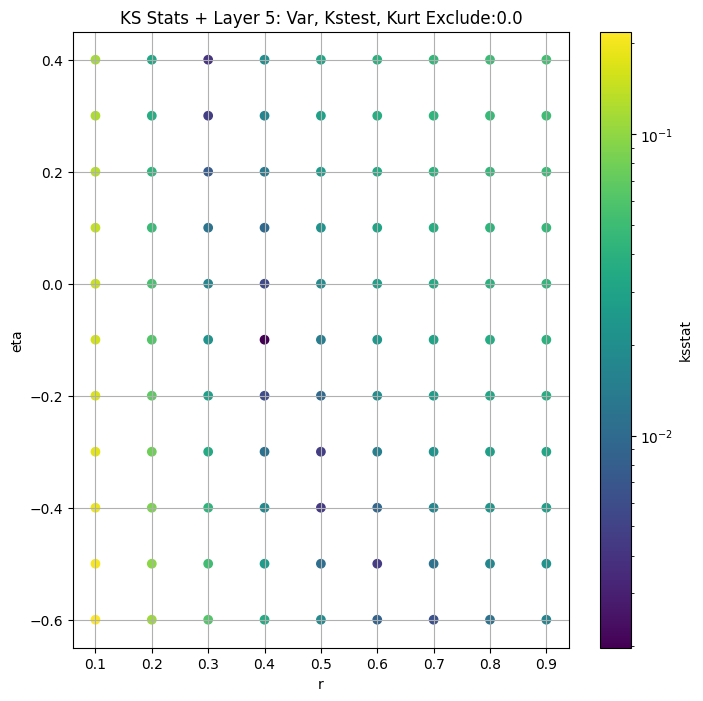

####
Layer  6


100%|██████████| 12760/12760 [00:40<00:00, 318.58it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.004722918783311103 8.706341


100%|██████████| 12760/12760 [00:42<00:00, 300.78it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.004972018702383729 8.438324


100%|██████████| 12760/12760 [00:38<00:00, 332.14it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.003892537814076502 8.264395


100%|██████████| 12760/12760 [00:41<00:00, 306.82it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.004546824682072237 8.118723


100%|██████████| 12760/12760 [00:38<00:00, 328.73it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.005182688753076092 7.989503


100%|██████████| 12760/12760 [00:40<00:00, 313.28it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.005796771024769831 7.764991


100%|██████████| 12760/12760 [00:37<00:00, 336.30it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005974893841427131 7.571101


100%|██████████| 12760/12760 [00:37<00:00, 342.06it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.006841945342724642 7.397577


100%|██████████| 12760/12760 [00:38<00:00, 331.30it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006543660943766905 7.239896


100%|██████████| 12760/12760 [00:40<00:00, 316.90it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.006846650341292837 7.0943217


100%|██████████| 12760/12760 [00:39<00:00, 326.61it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008460871417947935 6.7125645
Number of samples: 100000, Without approximation : 814080.0


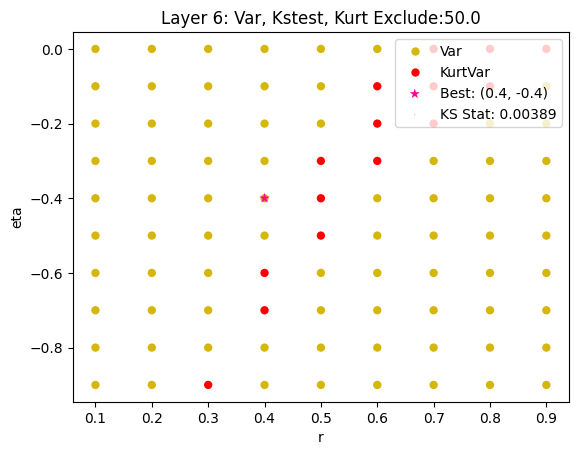

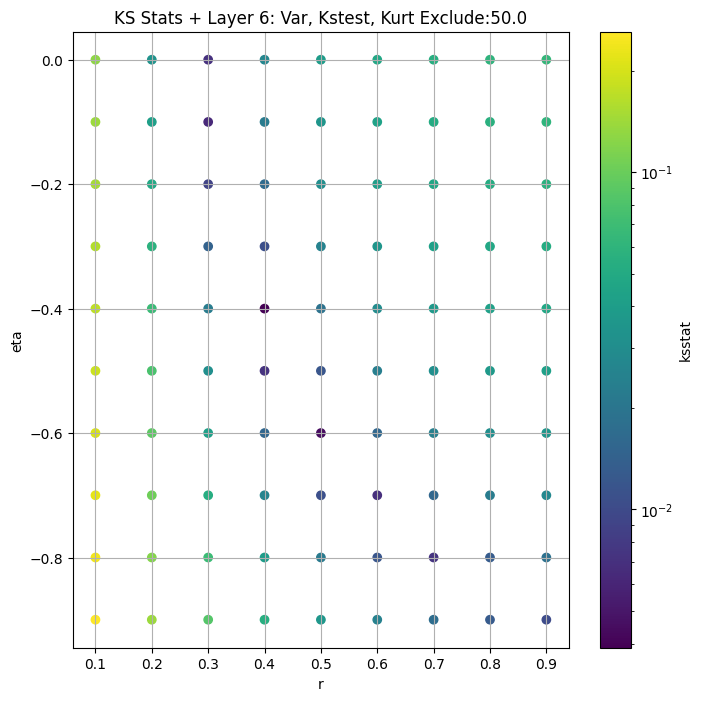

####
Layer  7


100%|██████████| 12760/12760 [00:38<00:00, 335.71it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.006029344391909497 1.6204807


100%|██████████| 12760/12760 [00:39<00:00, 325.41it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.005545286660588955 1.5620098


100%|██████████| 12760/12760 [00:42<00:00, 300.19it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.005506657424174444 1.5243894


100%|██████████| 12760/12760 [00:41<00:00, 306.54it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.006471574593377327 1.4930753


100%|██████████| 12760/12760 [00:41<00:00, 305.87it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.007448614652890373 1.4656034


100%|██████████| 12760/12760 [00:41<00:00, 309.42it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.006353916777231627 1.4178922


100%|██████████| 12760/12760 [00:38<00:00, 329.93it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.007200541951218886 1.3767599


100%|██████████| 12760/12760 [00:38<00:00, 335.52it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.008491203536778014 1.3401437


100%|██████████| 12760/12760 [00:38<00:00, 327.96it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.00788448877344694 1.3069865


100%|██████████| 12760/12760 [00:39<00:00, 321.94it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.007875876238341961 1.2765421


100%|██████████| 12760/12760 [00:42<00:00, 302.36it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.010344806166861786 1.1972713
Number of samples: 100000, Without approximation : 3256320.0


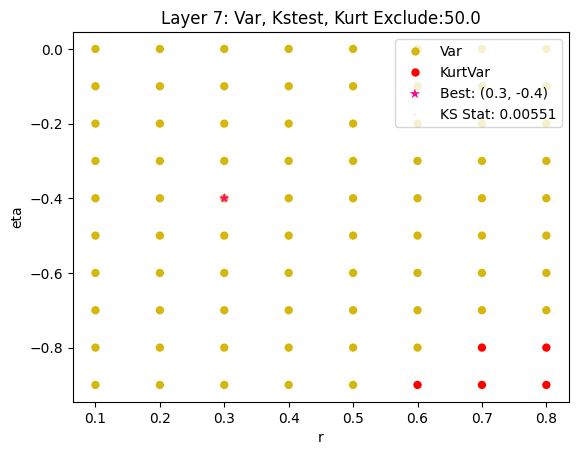

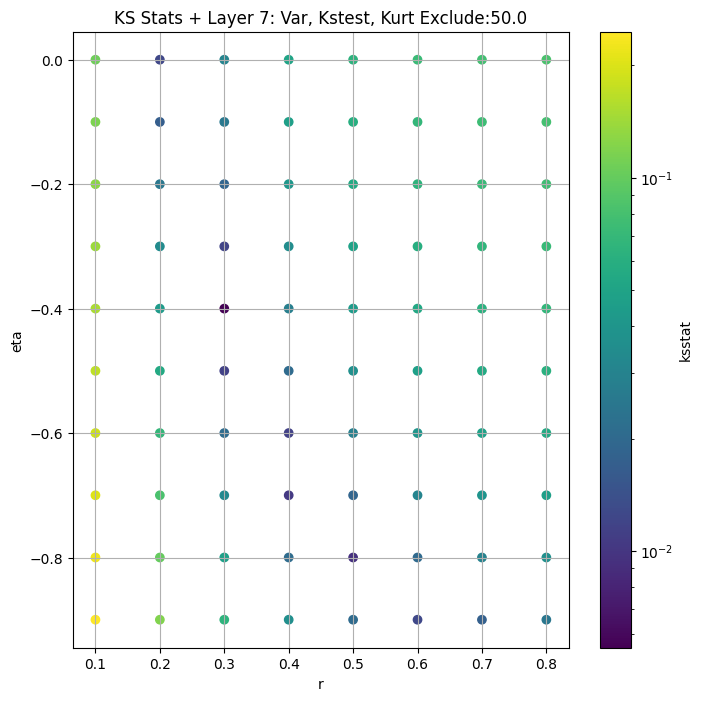

####
Layer  8


100%|██████████| 12760/12760 [00:41<00:00, 310.75it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.007077036566785155 0.25356194


100%|██████████| 12760/12760 [00:40<00:00, 317.49it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.00647385926766697 0.24203938


100%|██████████| 12760/12760 [00:41<00:00, 306.28it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.00693460099574833 0.23529685


100%|██████████| 12760/12760 [00:43<00:00, 291.76it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.00765951975028456 0.22978303


100%|██████████| 12760/12760 [00:44<00:00, 287.89it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.007472340310150982 0.22498319


100%|██████████| 12760/12760 [00:40<00:00, 313.35it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.008927350237321163 0.21673694


100%|██████████| 12760/12760 [00:40<00:00, 318.11it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.007869140649472306 0.20969005


100%|██████████| 12760/12760 [00:38<00:00, 331.72it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.008954137663612194 0.20346807


100%|██████████| 12760/12760 [00:42<00:00, 303.38it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.010109882419961358 0.19786178


100%|██████████| 12760/12760 [00:45<00:00, 279.01it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.009646274927946341 0.19274783


100%|██████████| 12760/12760 [00:47<00:00, 267.40it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.011894076329613479 0.17955974
Number of samples: 100000, Without approximation : 13025280.0


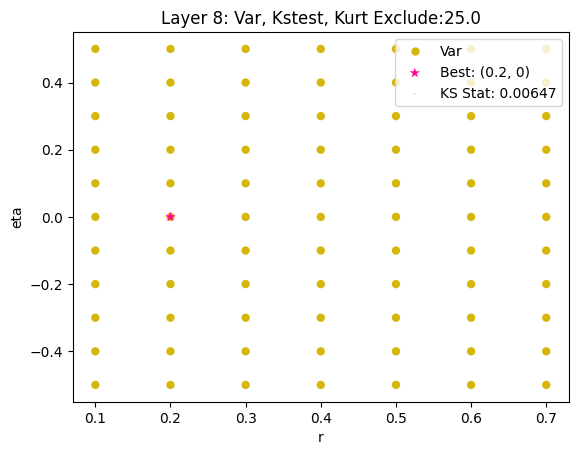

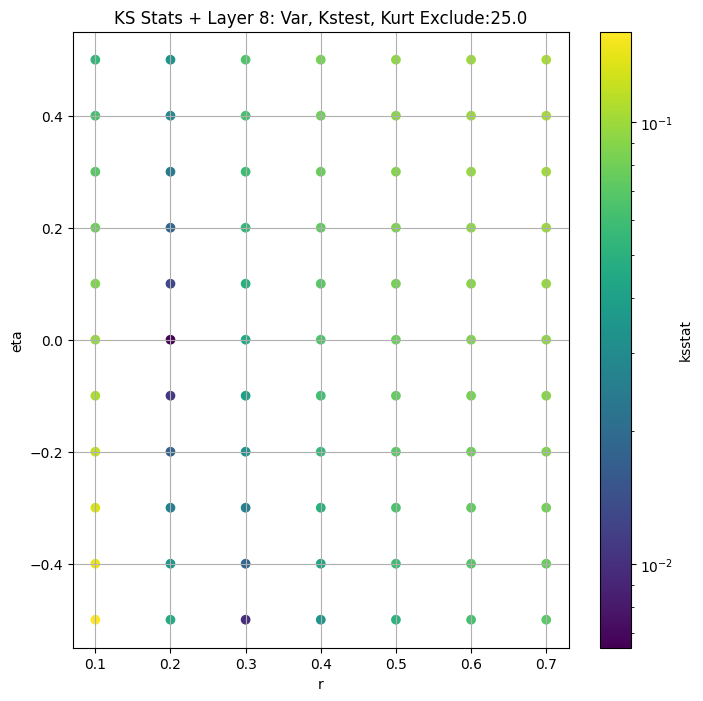

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2115.980000  1901.711800  2349.228000   3.403383    1.992058   
3       673.217470   635.692300   712.868700   3.037643    2.285118   
4       188.343120   177.020320   200.117230   3.632319    2.853501   
5        43.649445    40.704983    46.747660   5.291733    4.145431   
6         8.706341     8.027619     9.425082   7.502429    5.632719   
7         1.620481     1.481642     1.770143  10.018490    7.480563   
8         0.253562     0.229370     0.281929  13.938591    9.163198   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.968096         3180.0             0.018264        0.2          3.8   
3        3.923036        12720.0             0.004540        0.3          2.1   
4        4.629042        50880.0             0.005056        0.6         -0.1   
5        6.736124       203520.0             0.001980        0.4         -0.1   
6       10.357133       814080.0             0.003893        0.4         -0.4   
7       14.607306      3256320.0             0.005507        0.3         -0.4   
8       30.660614     13025280.0             0.006474        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.000113                     0.0         2115.980000   
3           0.125922                     0.0          673.217470   
4          36.159036                    25.0          182.216570   
5           1.208854                     0.0           43.649445   
6           0.377492                    50.0            8.264395   
7           0.008495                    50.0            1.524389   
8           0.000003                    25.0            0.242039   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 621/621 [00:00<00:00, 2091.35it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.049028762035218554, var: 1179.0159912109375


100%|██████████| 621/621 [00:00<00:00, 8081.84it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.040587363178343994, var: 1302.05810546875


100%|██████████| 621/621 [00:00<00:00, 8040.08it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.030466055971585027, var: 1456.05517578125


100%|██████████| 621/621 [00:00<00:00, 7768.50it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02279782995851981, var: 1662.3878173828125


100%|██████████| 621/621 [00:00<00:00, 7680.31it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.018264043866442425, var: 2115.97998046875
Number of samples: 3180, Without approximation : 3180.0


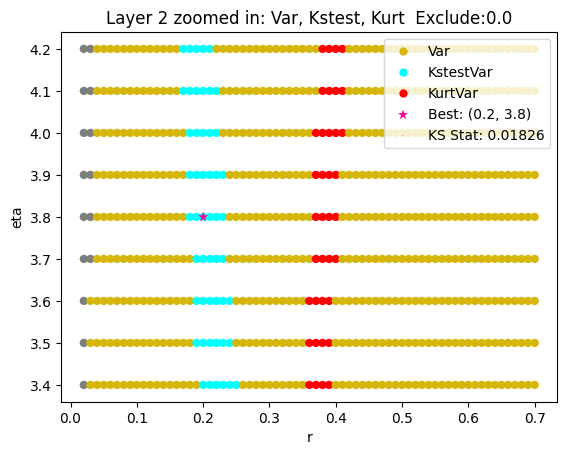

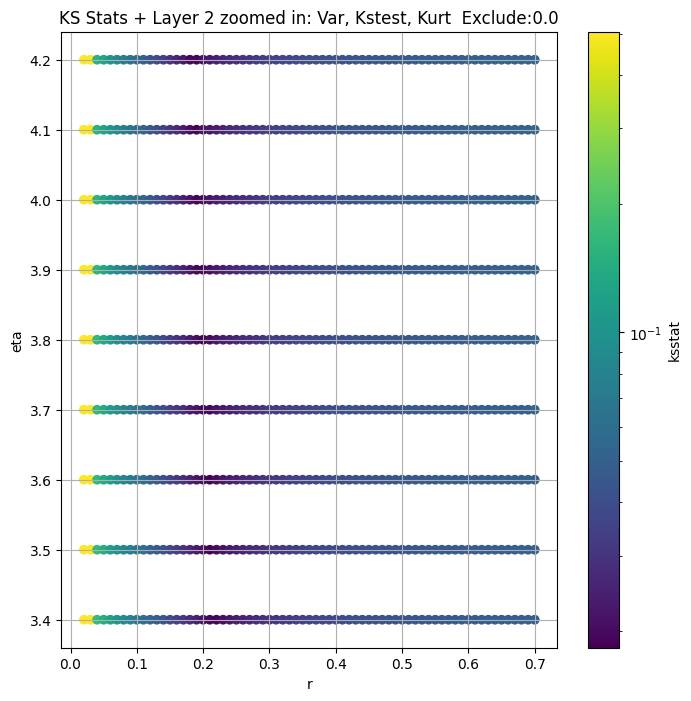

Layer 3


100%|██████████| 702/702 [00:00<00:00, 1296.04it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.015680023230254525, var: 535.810302734375


100%|██████████| 702/702 [00:00<00:00, 2516.69it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.013130378955307553, var: 558.5364990234375


100%|██████████| 702/702 [00:00<00:00, 2446.33it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010525115787159312, var: 584.9152221679688


100%|██████████| 702/702 [00:00<00:00, 2494.22it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007807623488702897, var: 616.78466796875


100%|██████████| 702/702 [00:00<00:00, 2552.76it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004540300105681738, var: 673.2174682617188
Number of samples: 12720, Without approximation : 12720.0


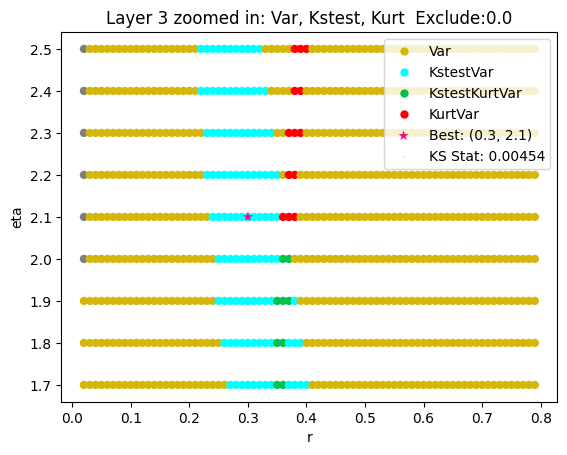

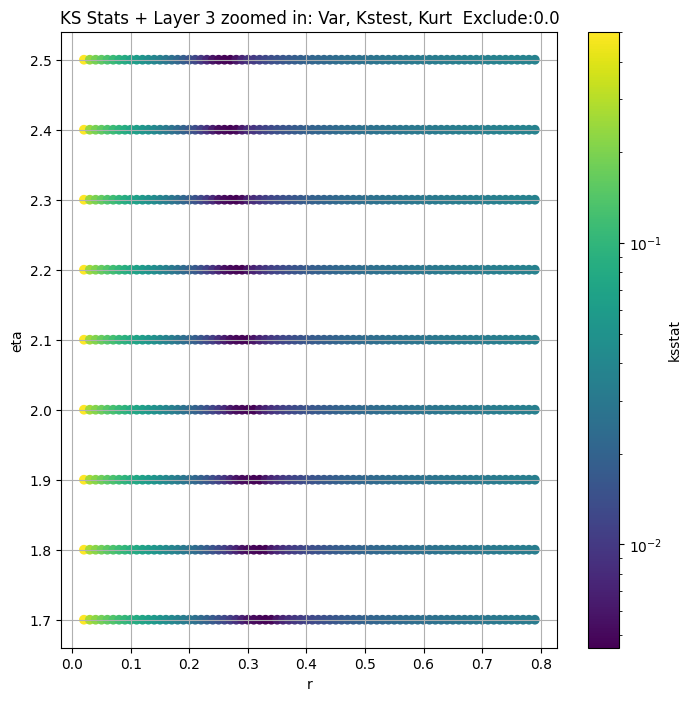

Layer 4


100%|██████████| 1377/1377 [00:03<00:00, 440.88it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.006659957426752183, var: 168.9475555419922


100%|██████████| 1377/1377 [00:02<00:00, 625.52it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.005856268726406211, var: 171.7369842529297


100%|██████████| 1377/1377 [00:02<00:00, 616.53it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.005411807804197033, var: 174.77882385253906


100%|██████████| 1377/1377 [00:02<00:00, 630.25it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.005043839027019659, var: 178.1985626220703


100%|██████████| 1377/1377 [00:02<00:00, 680.27it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.004907172332493104, var: 182.21656799316406


100%|██████████| 1377/1377 [00:02<00:00, 665.26it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.004827851106558145, var: 188.34312438964844
Number of samples: 50880, Without approximation : 50880.0


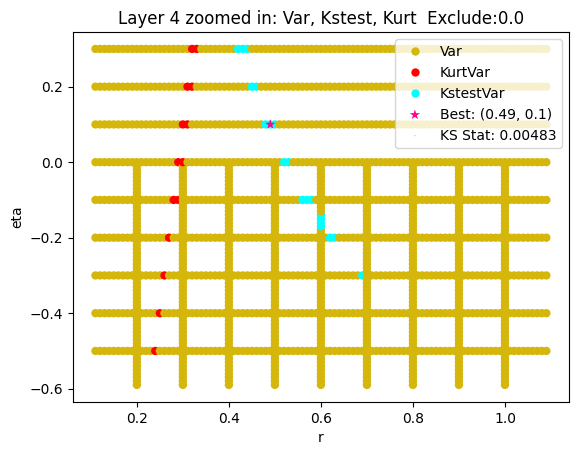

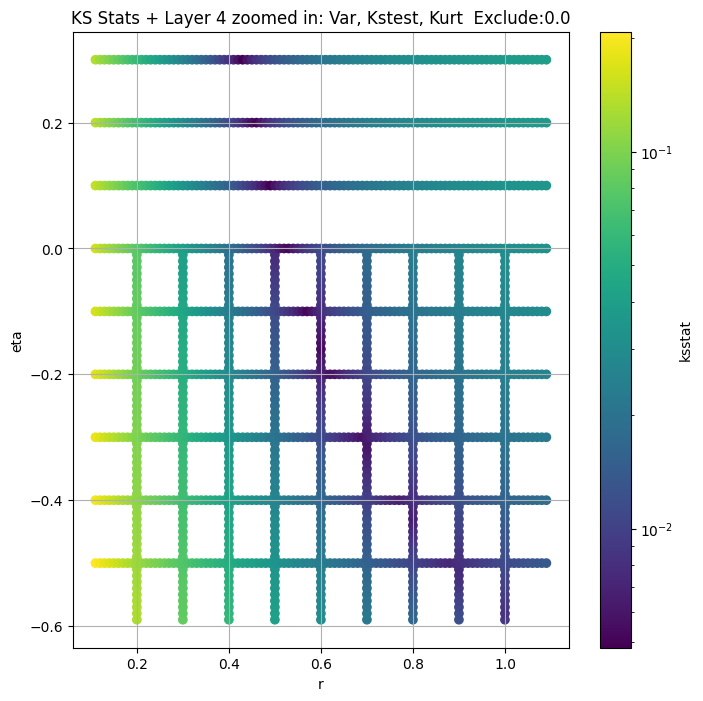

Layer 5


100%|██████████| 1224/1224 [00:03<00:00, 336.94it/s]


Finding Minimum after computing 1224 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0033814628873466424, var: 40.67973327636719


100%|██████████| 1224/1224 [00:03<00:00, 310.14it/s]


Finding Minimum after computing 1224 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0030126114677446747, var: 41.23994827270508


100%|██████████| 1224/1224 [00:03<00:00, 331.22it/s]


Finding Minimum after computing 1224 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0026613430393302717, var: 41.8682975769043


100%|██████████| 1224/1224 [00:03<00:00, 329.34it/s]


Finding Minimum after computing 1224 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0022661538733093067, var: 42.60478210449219


100%|██████████| 1224/1224 [00:03<00:00, 334.14it/s]


Finding Minimum after computing 1224 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.001980108018862836, var: 43.649444580078125
Number of samples: 100000, Without approximation : 203520.0


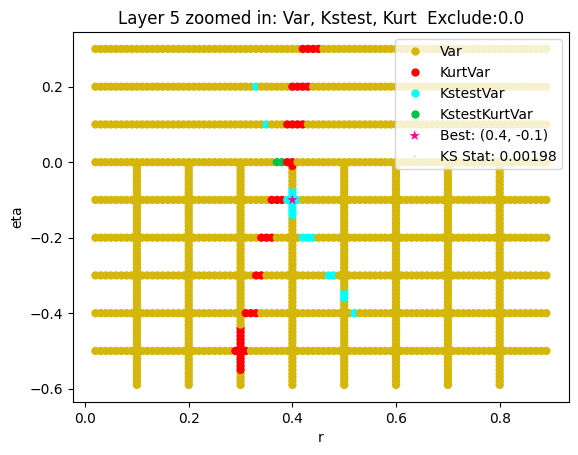

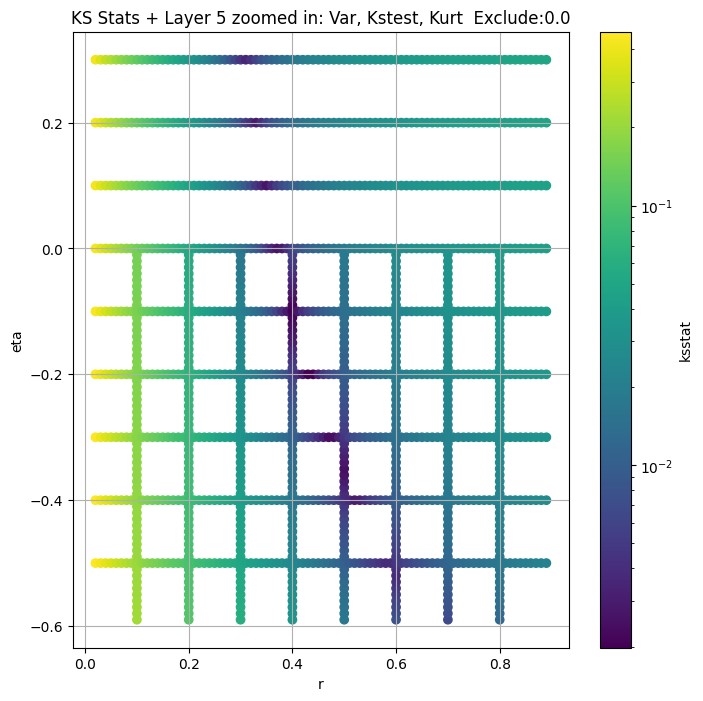

Layer 6


100%|██████████| 1440/1440 [00:04<00:00, 318.47it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.004645825570772755, var: 7.76499080657959


100%|██████████| 1440/1440 [00:05<00:00, 281.19it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.00440607590006481, var: 7.872632026672363


100%|██████████| 1440/1440 [00:05<00:00, 277.12it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.004140140884860699, var: 7.989502906799316


100%|██████████| 1440/1440 [00:04<00:00, 343.44it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.0037076727599362203, var: 8.118722915649414


100%|██████████| 1440/1440 [00:04<00:00, 321.95it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.0036695796970799277, var: 8.264394760131836


100%|██████████| 1440/1440 [00:05<00:00, 243.18it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.003408966252436585, var: 8.438323974609375


100%|██████████| 1440/1440 [00:04<00:00, 311.76it/s]


Finding Minimum after computing 1440 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.00341883621223088, var: 8.706340789794922
Number of samples: 100000, Without approximation : 814080.0


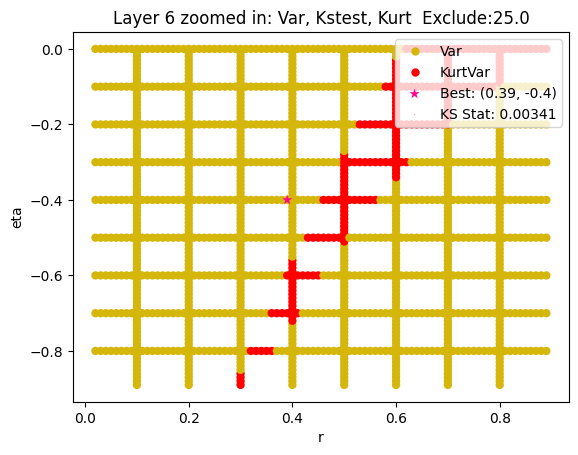

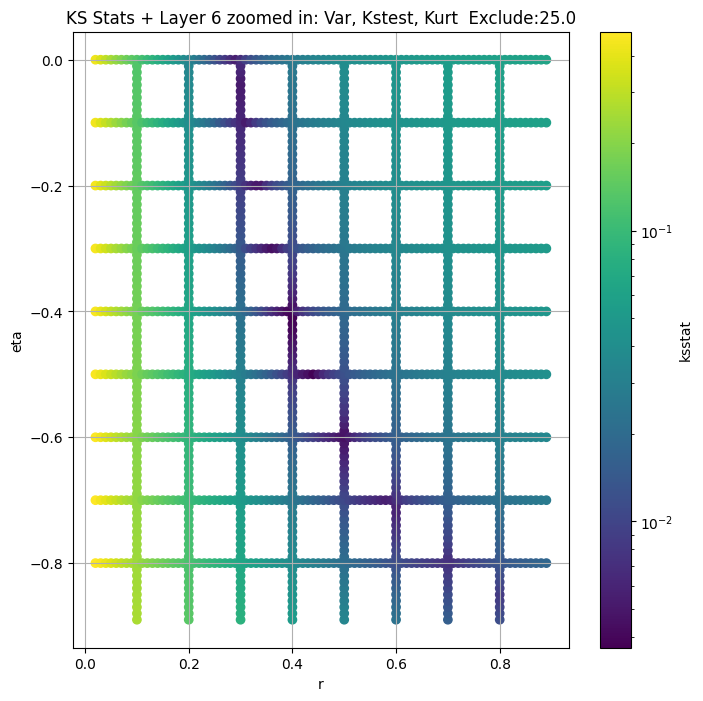

Layer 7


100%|██████████| 1269/1269 [00:03<00:00, 331.90it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.006243044402465425, var: 1.4178922176361084


100%|██████████| 1269/1269 [00:03<00:00, 344.81it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.006181423508553996, var: 1.4407621622085571


100%|██████████| 1269/1269 [00:03<00:00, 348.80it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.005958064144112707, var: 1.4656033515930176


100%|██████████| 1269/1269 [00:03<00:00, 346.49it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.0055570628586331106, var: 1.4930752515792847


100%|██████████| 1269/1269 [00:03<00:00, 349.08it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.0052060680311093455, var: 1.524389386177063


100%|██████████| 1269/1269 [00:03<00:00, 345.94it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.00532046114317597, var: 1.5620098114013672


100%|██████████| 1269/1269 [00:03<00:00, 341.18it/s]


Finding Minimum after computing 1269 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.0048174888198818655, var: 1.6204806566238403
Number of samples: 100000, Without approximation : 3256320.0


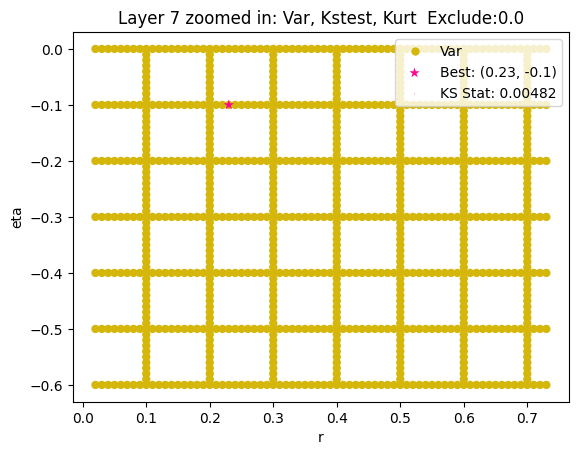

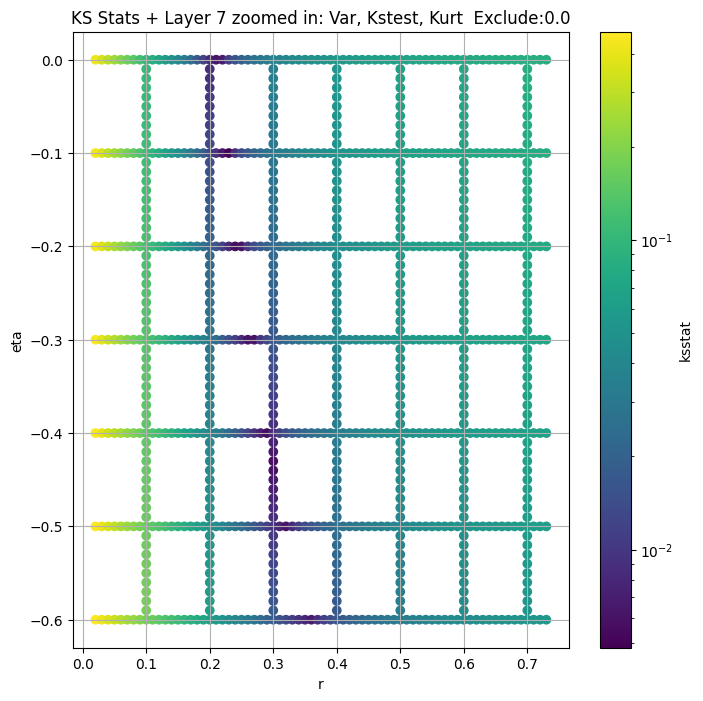

Layer 8


100%|██████████| 936/936 [00:02<00:00, 339.15it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.007250863748916592, var: 0.22067631781101227


100%|██████████| 936/936 [00:02<00:00, 347.11it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.006727080852250267, var: 0.22498318552970886


100%|██████████| 936/936 [00:02<00:00, 343.75it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.006521896679383743, var: 0.22978302836418152


100%|██████████| 936/936 [00:02<00:00, 347.15it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.006589021197812017, var: 0.2352968454360962


100%|██████████| 936/936 [00:02<00:00, 337.33it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.006385498270812806, var: 0.24203938245773315


100%|██████████| 936/936 [00:02<00:00, 347.41it/s]


Finding Minimum after computing 936 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.006887236558339949, var: 0.25356194376945496
Number of samples: 100000, Without approximation : 13025280.0


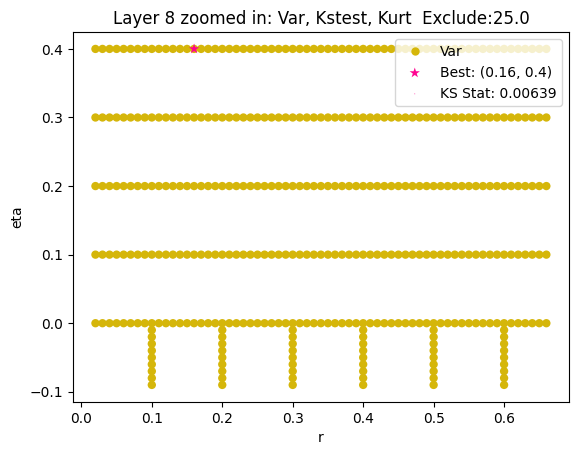

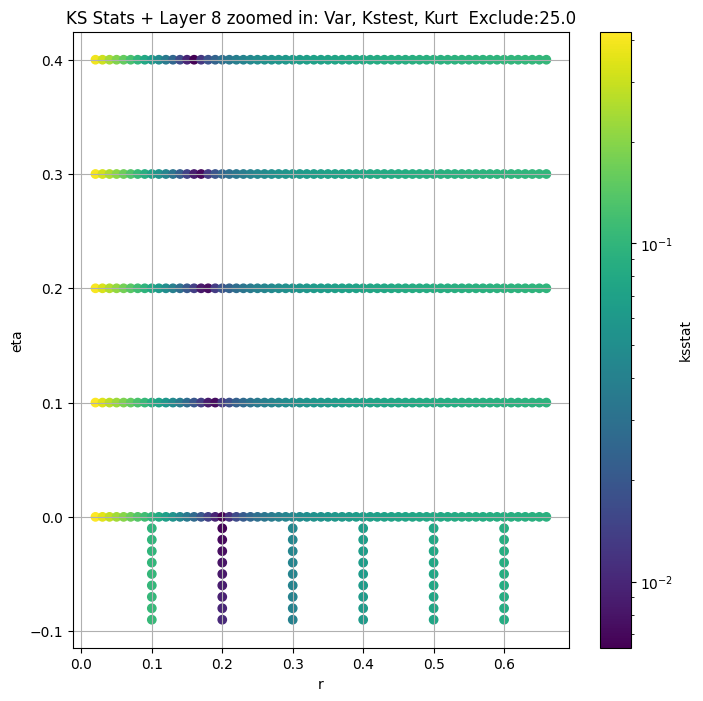

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2115.980000  1901.711800  2349.228000   3.403383    1.992058   
3       673.217470   635.692300   712.868700   3.037643    2.285118   
4       188.343120   177.020320   200.117230   3.632319    2.853501   
5        43.649445    40.704983    46.747660   5.291733    4.145431   
6         8.706341     8.027619     9.425082   7.502429    5.632719   
7         1.620481     1.481642     1.770143  10.018490    7.480563   
8         0.253562     0.229370     0.281929  13.938591    9.163198   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.968096         3180.0             0.018264        0.2          3.8   
3        3.923036        12720.0             0.004540        0.3          2.1   
4        4.629042        50880.0             0.005056        0.6         -0.1   
5        6.736124       203520.0             0.001980        0.4         -0.1   
6       10.357133       814080.0             0.003893        0.4         -0.4   
7       14.607306      3256320.0             0.005507        0.3         -0.4   
8       30.660614     13025280.0             0.006474        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.000113                     0.0         2115.980000   
3           0.125922                     0.0          673.217470   
4          36.159036                    25.0          188.343124   
5           1.208854                     0.0           43.649445   
6           0.377492                    50.0            8.438324   
7           0.008495                    50.0            1.620481   
8           0.000003                    25.0            0.242039   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.018264    0.20       3.8   
3                     0.012029          0.004540    0.30       2.1   
4                     0.006018          0.004828    0.49       0.1   
5                     0.003010          0.001980    0.40      -0.1   
6                     0.001505          0.003409    0.39      -0.4   
7                     0.000753          0.004817    0.23      -0.1   
8                     0.000376          0.006385    0.16       0.4   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.132312e-04                  0.0         5365  
3      1.259217e-01                  0.0        91686  
4      1.268501e+01                  0.0        76320  
5      1.208854e+00                  0.0       457920  
6      3.307351e-01                 25.0       152640  
7      2.313942e-04                  0.0        76320  
8      1.399859e-08                 25.0        45840

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

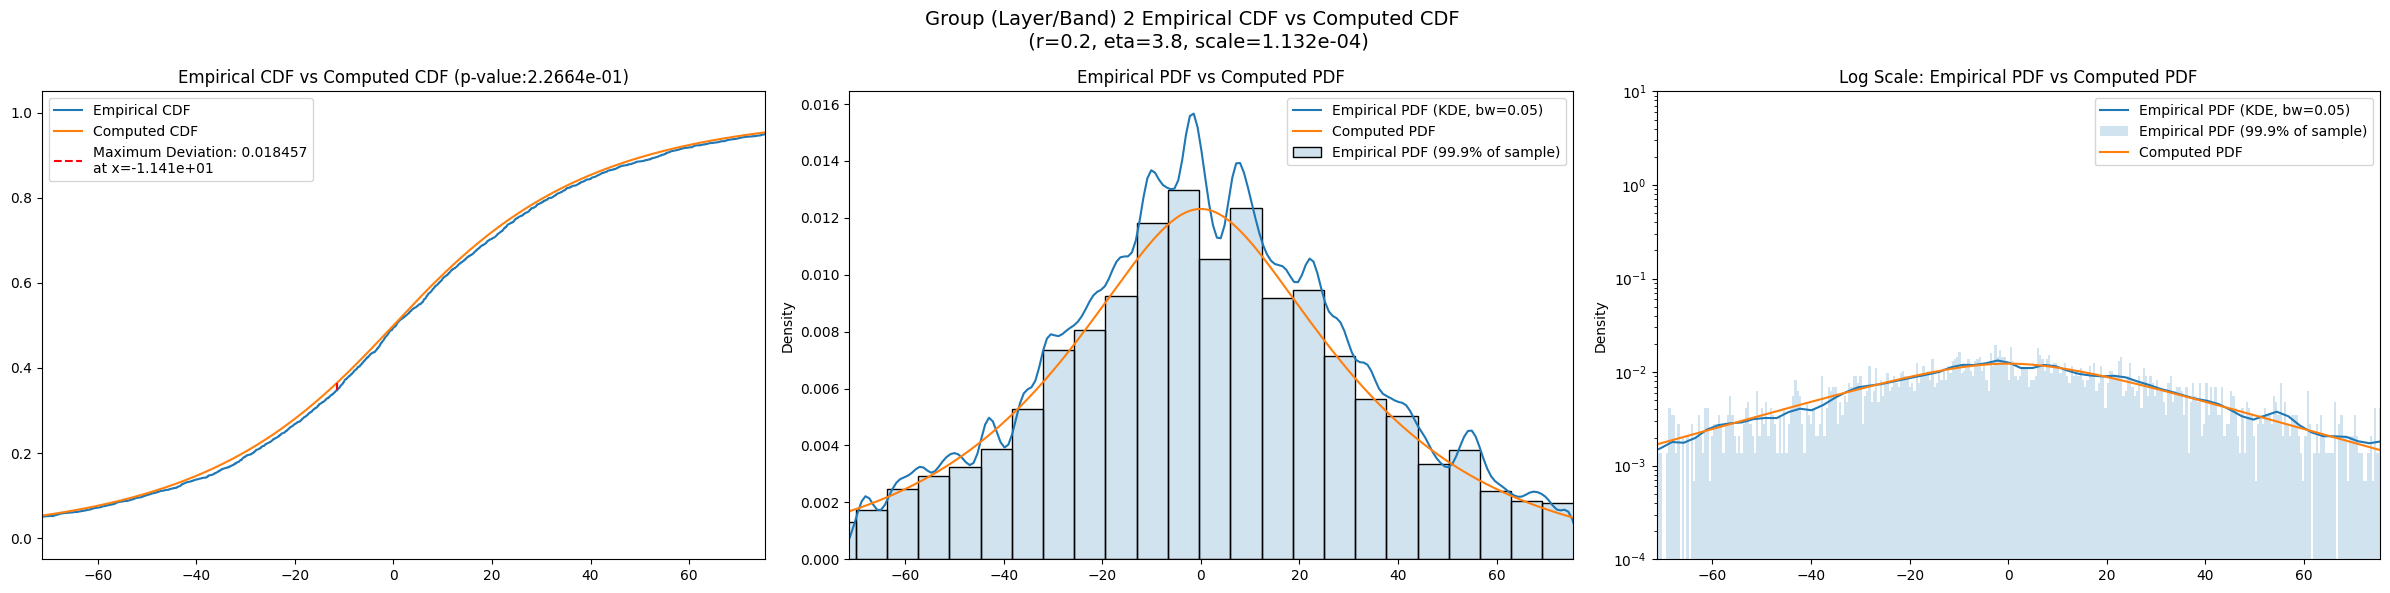

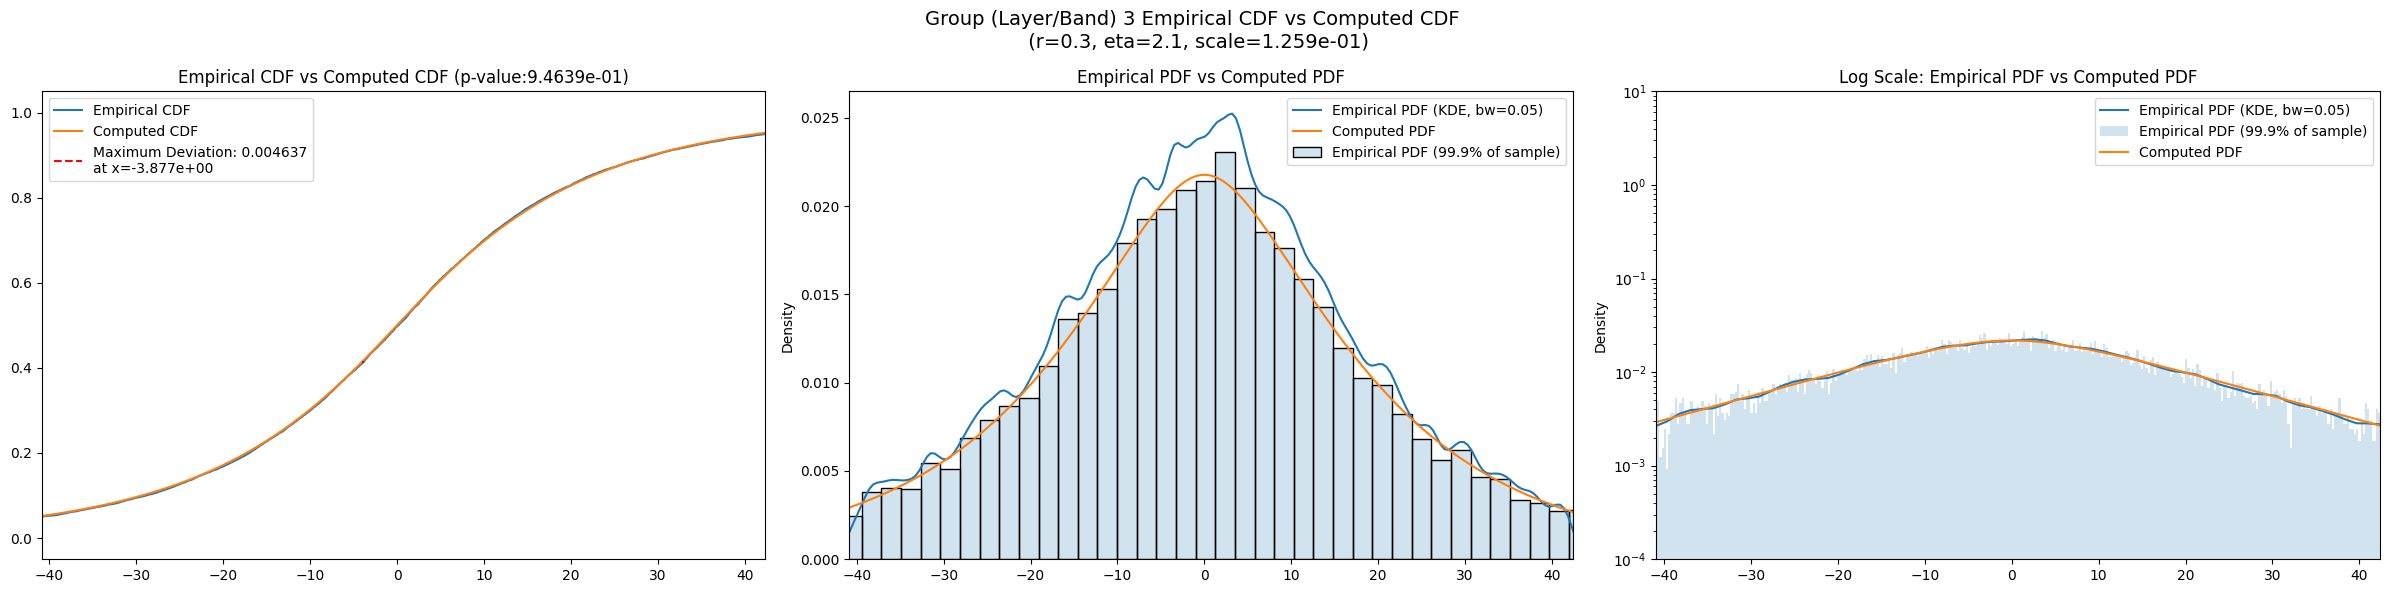

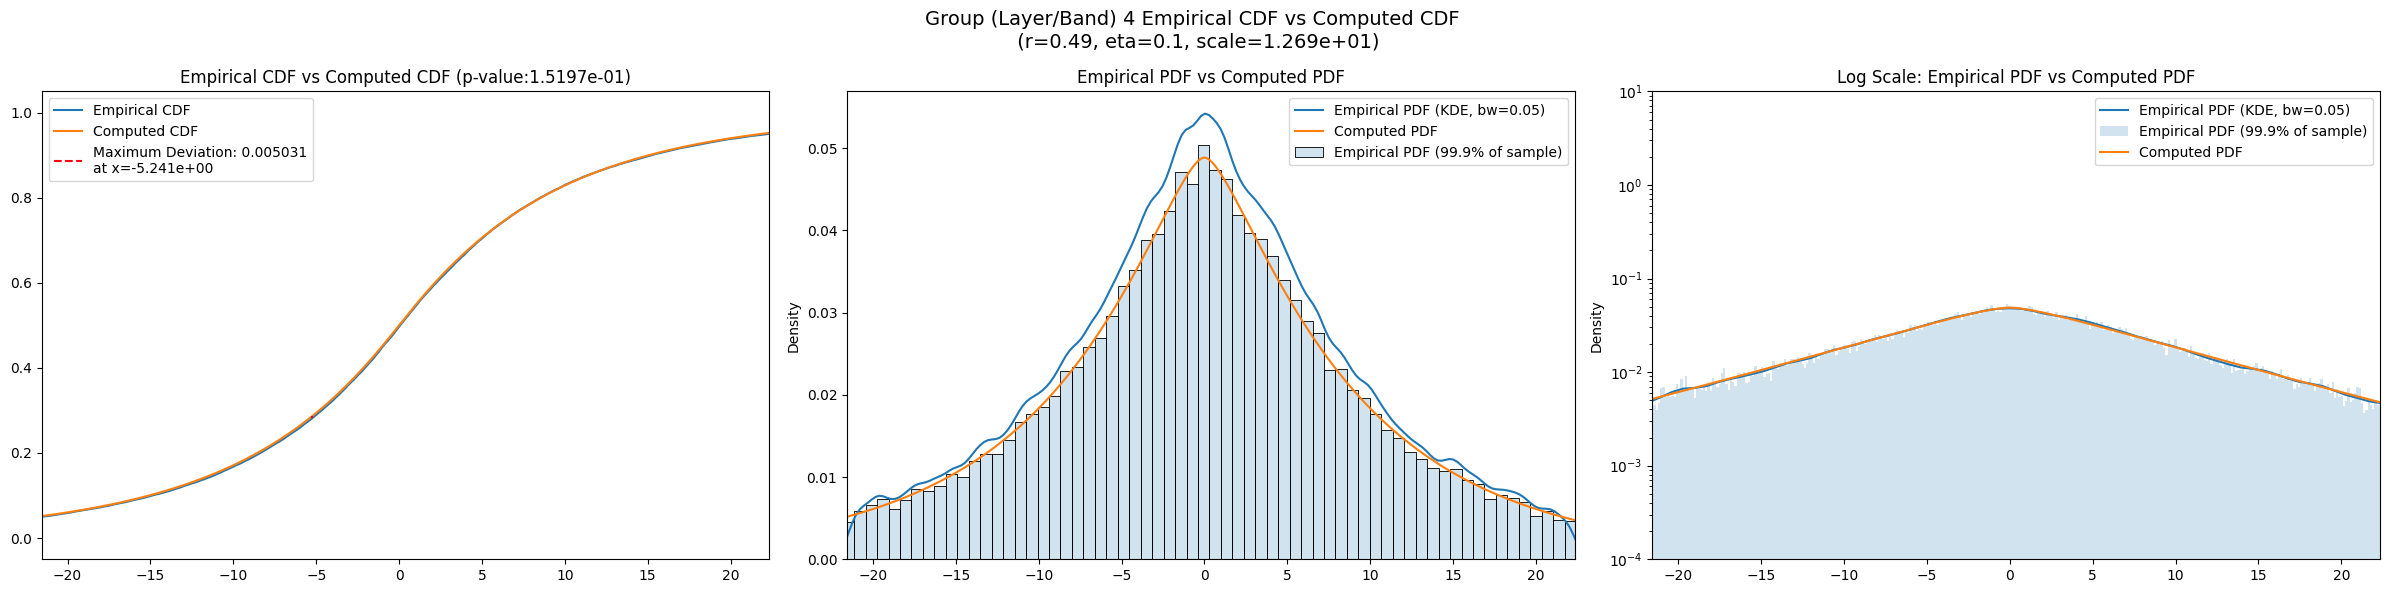

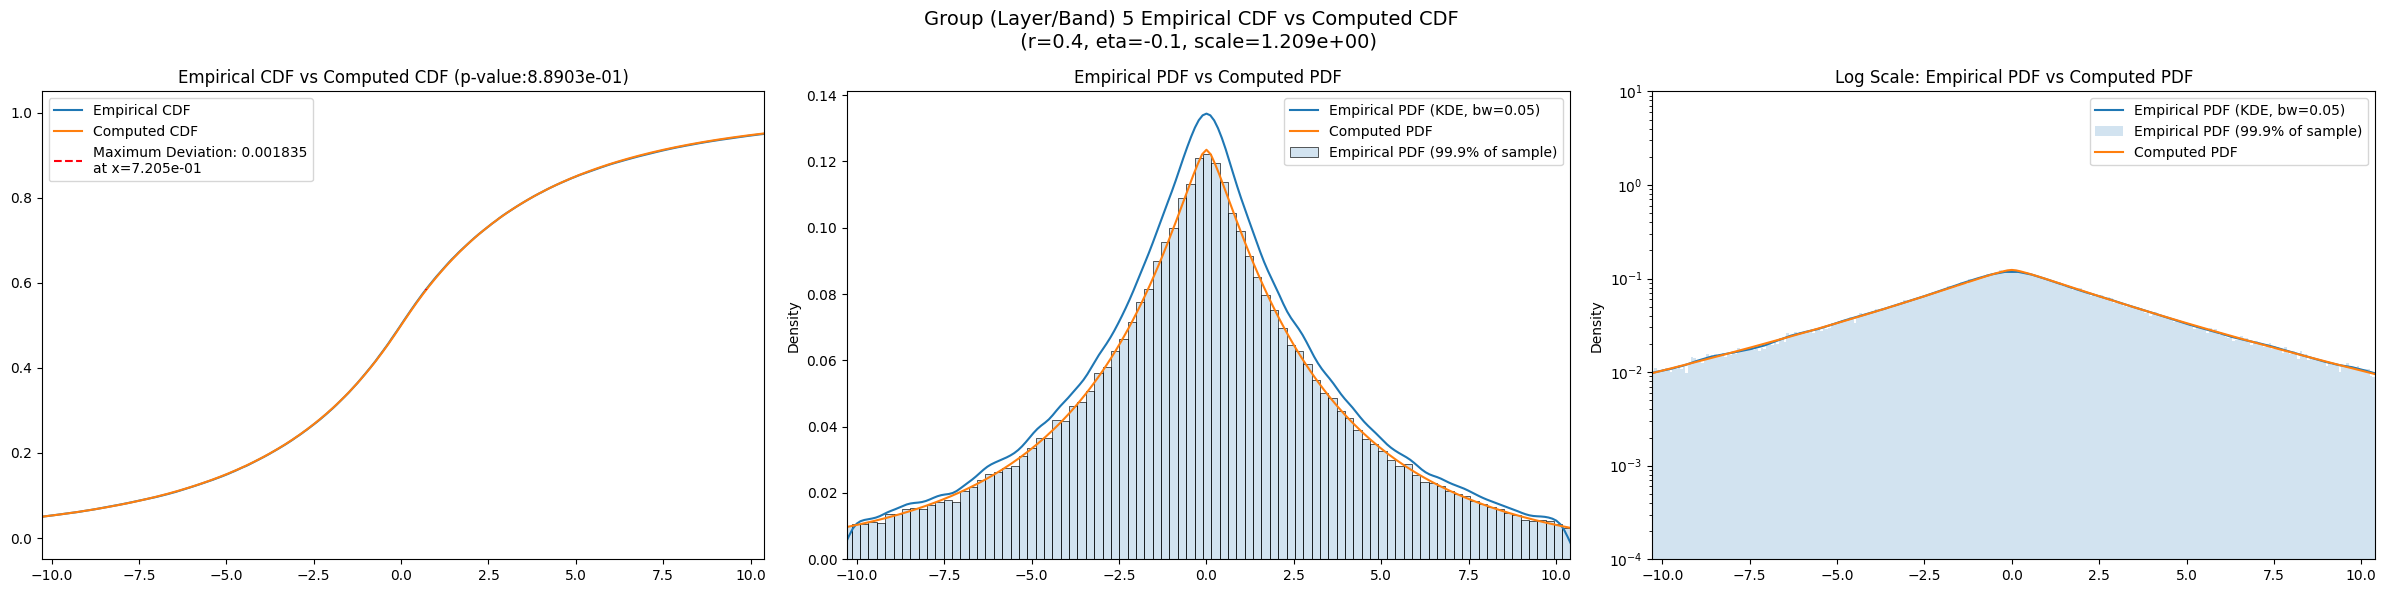

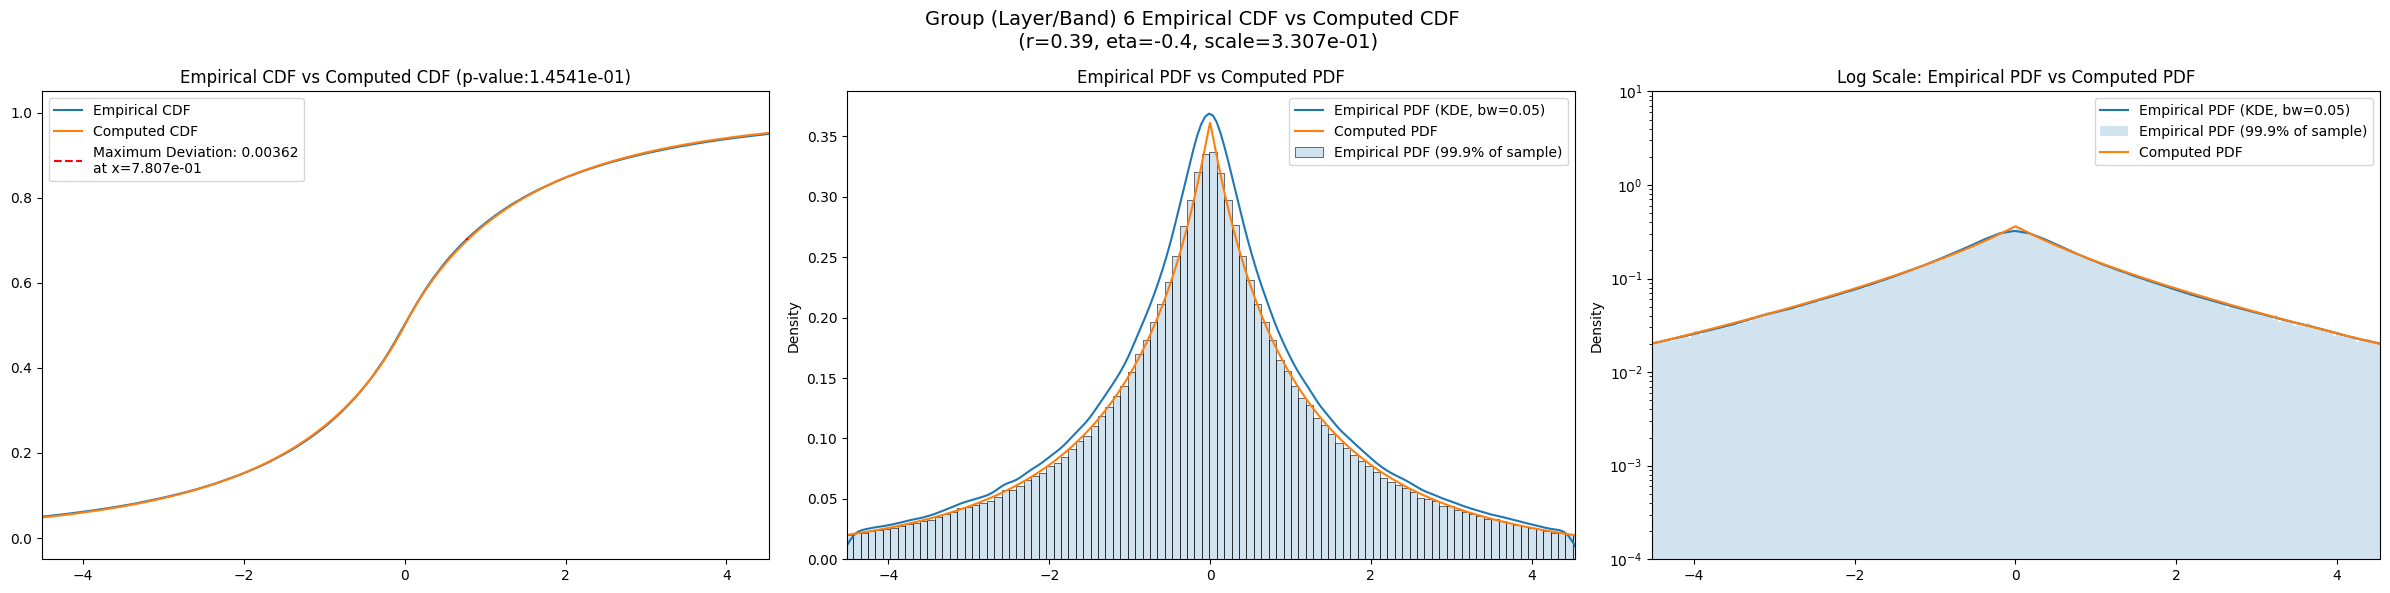

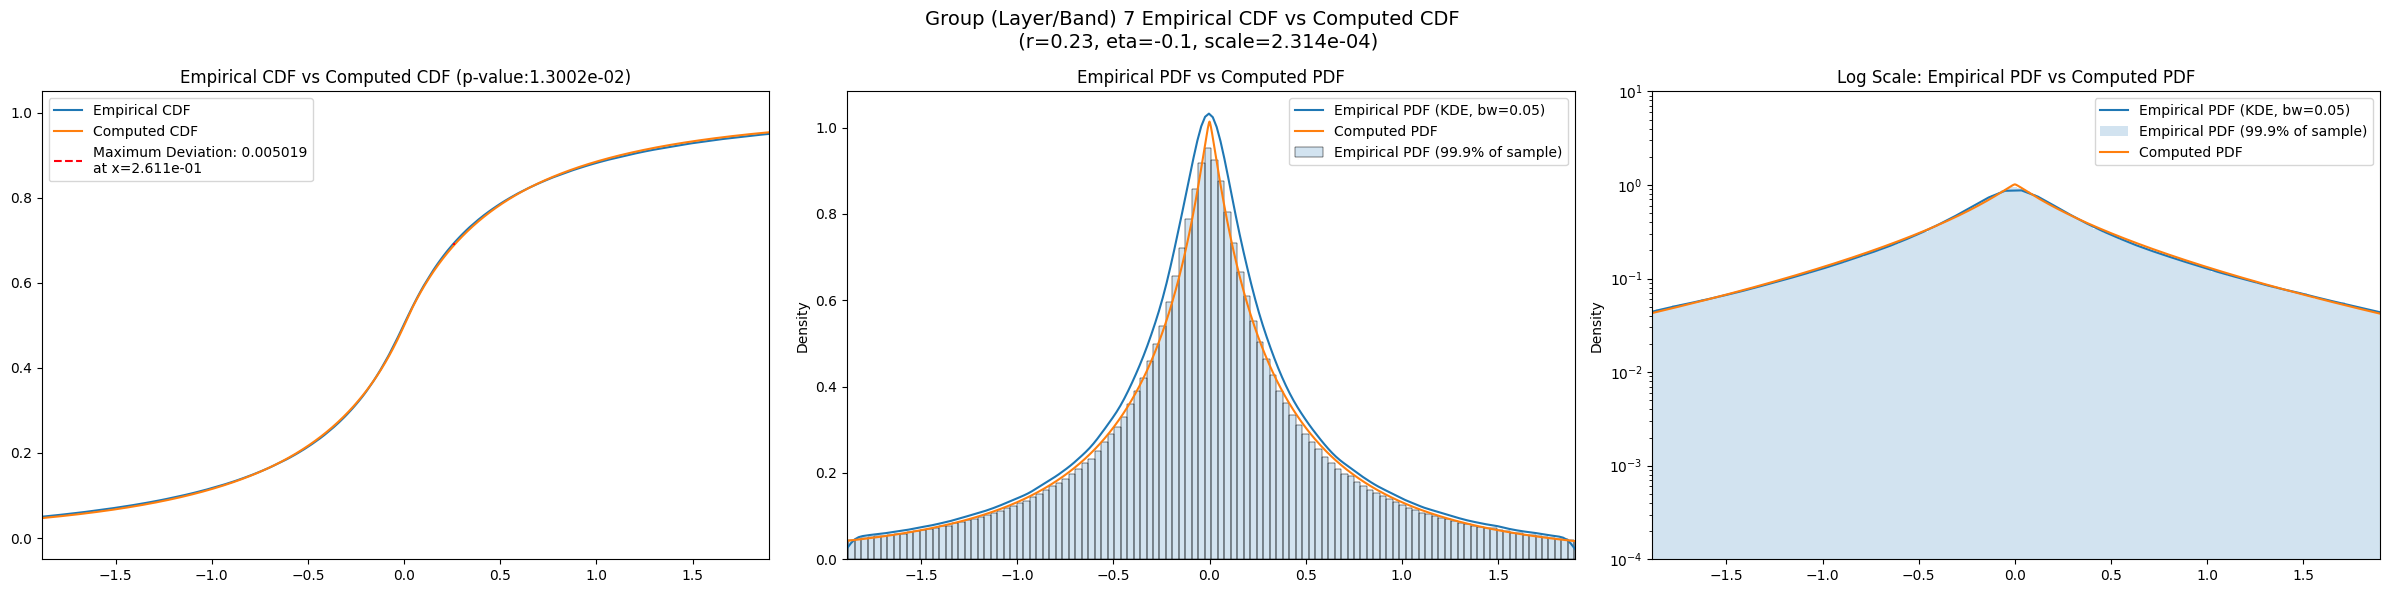

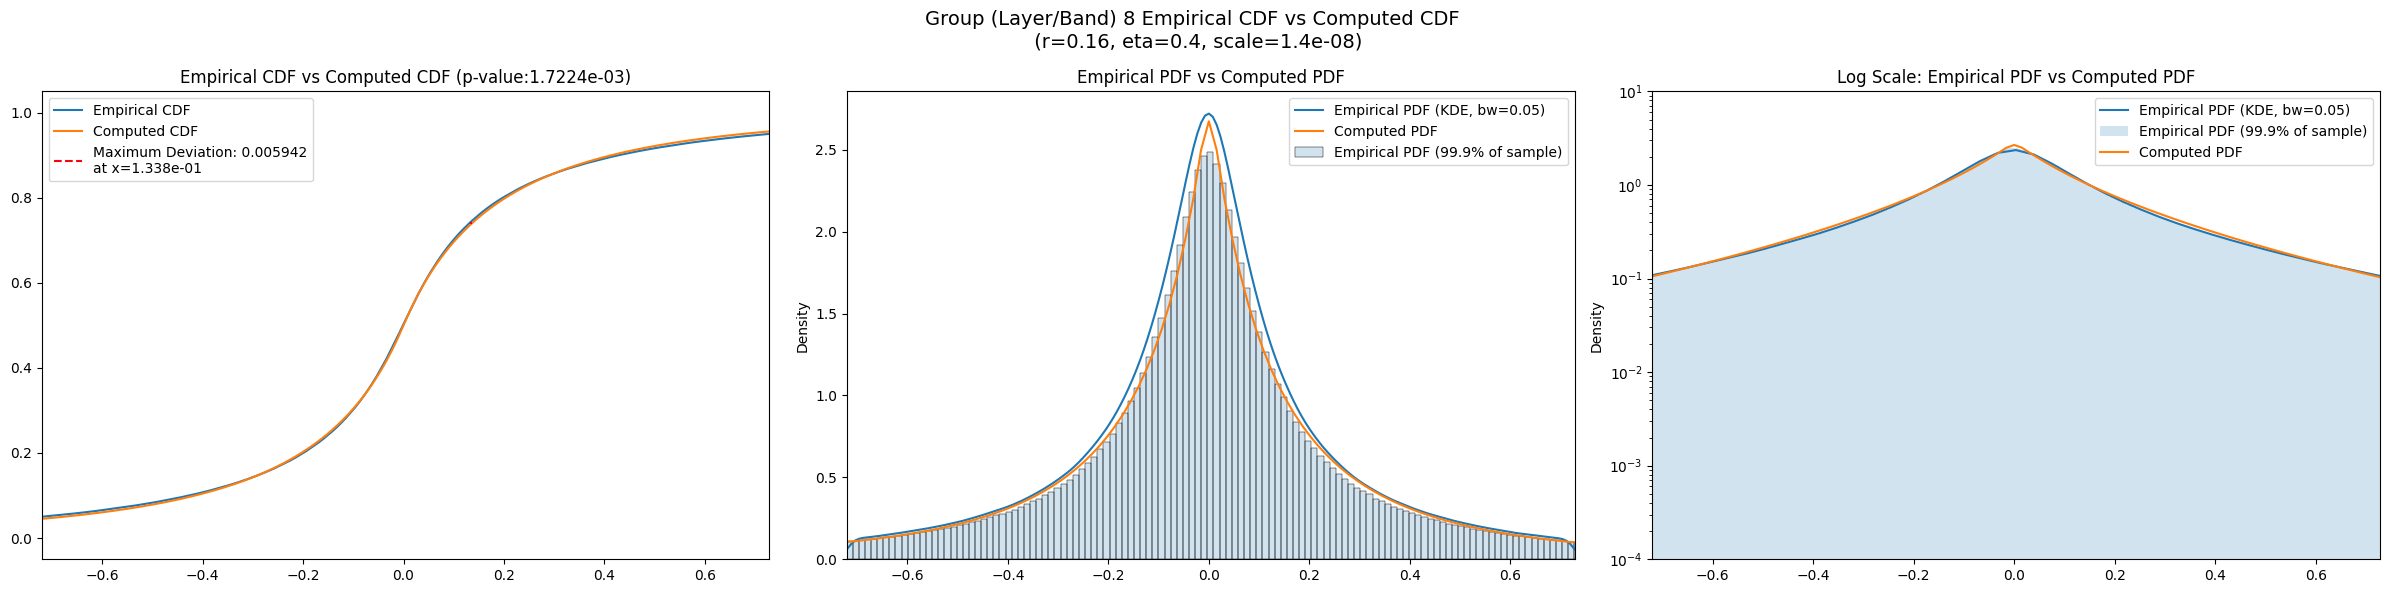

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2115.980000  1901.711800  2349.228000   3.403383    1.992058   
3       673.217470   635.692300   712.868700   3.037643    2.285118   
4       188.343120   177.020320   200.117230   3.632319    2.853501   
5        43.649445    40.704983    46.747660   5.291733    4.145431   
6         8.706341     8.027619     9.425082   7.502429    5.632719   
7         1.620481     1.481642     1.770143  10.018490    7.480563   
8         0.253562     0.229370     0.281929  13.938591    9.163198   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.968096         3180.0             0.018264        0.2          3.8   
3        3.923036        12720.0             0.004540        0.3          2.1   
4        4.629042        50880.0             0.005056        0.6         -0.1   
5        6.736124       203520.0             0.001980        0.4         -0.1   
6       10.357133       814080.0             0.003893        0.4         -0.4   
7       14.607306      3256320.0             0.005507        0.3         -0.4   
8       30.660614     13025280.0             0.006474        0.2          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       37.203200              0.032522          2.342390e-03   
3      ...       21.853600              0.024881          2.840980e-07   
4      ...       10.744600              0.031907          1.946060e-45   
5      ...        4.789100              0.036596         2.992900e-237   
6      ...        1.900440              0.045304          0.000000e+00   
7      ...        0.723649              0.053248          0.000000e+00   
8      ...        0.266859              0.055119          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          34.638400             0.024431         4.418570e-02  28.837300   
3          19.103600             0.010638         1.115630e-01  15.323100   
4           9.453900             0.006362         3.238610e-02   7.726380   
5           4.201040             0.009074         5.521950e-15   3.405780   
6           1.666850             0.017626        3.995990e-220   1.339960   
7           0.634893             0.025758         0.000000e+00   0.505936   
8           0.235386             0.028126         0.000000e+00   0.186699   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018513   2.230420e-01          2.363986e-01  
3           0.012646   3.391310e-02          9.546210e-01  
4           0.009248   3.301150e-04          1.858686e-01  
5           0.011863   2.625010e-25          4.015450e-01  
6           0.019561  5.191030e-271          1.209953e-08  
7           0.026180   0.000000e+00          4.544463e-66  
8           0.026473   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.018264                 0.024030          0.018264   
3                 0.004540                 0.012029          0.004540   
4                 0.005056                 0.006018          0.004828   
5                 0.001980                 0.003010          0.001980   
6                 0.003893                 0.001505          0.003409   
7                 0.005507                 0.000753          0.004817   
8                 0.006474                 0.000376          0.006385   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.032522             0.024431       0.018513  
3                  0.024881             0.010638       0.012646  
4                  0.031907             0.006362       0.009248  
5                  0.036596             0.009074       0.011863  
6                  0.045304             0.017626       0.019561  
7                  0.053248             0.025758       0.026180  
8                  0.055119             0.028126       0.026473

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             2115.980000          0.018264    0.20       3.8  1.132312e-04   
3              673.217470          0.004540    0.30       2.1  1.259217e-01   
4              188.343124          0.004828    0.49       0.1  1.268501e+01   
5               43.649445          0.001980    0.40      -0.1  1.208854e+00   
6                8.438324          0.003409    0.39      -0.4  3.307351e-01   
7                1.620481          0.004817    0.23      -0.1  2.313942e-04   
8                0.242039          0.006385    0.16       0.4  1.399859e-08   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                     25.0  
7                      0.0  
8                     25.0

In [21]:
eng.quit()